* Data cleansing

In [ ]:
import pandas as pd
from google.colab import drive

drive.mount('/content/gdrive')

input_file_path = '/content/gdrive/My Drive/NewsClassification/Datasets/original.csv'
output_file_path = '/content/gdrive/My Drive/NewsClassification/Datasets/dataset.csv'

df = pd.read_csv(input_file_path)

# categories to be removed
categories_to_remove = ['ARTS & CULTURE', 'MEDIA', 'CRIME', 'RELIGION', 'COMEDY', 'WOMEN', 'EDUCATION', 'ENTERTAINMENT']

# Remove rows with specified categories
df_cleaned = df[~df['category'].isin(categories_to_remove)]

# Drop rows with empty values in other specified columns
df_cleaned = df_cleaned.dropna(subset=['title', 'body'])

# Save the cleaned dataset to a new CSV file
df_cleaned.to_csv(output_file_path, index=False)

Mounted at /content/gdrive


* Data splitting ensuring that there are enough data for each category | The stratify parameter ensures that the distribution of categories is preserved in each split.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from google.colab import drive # Use Google classes

drive.mount('/content/gdrive') # Mount Google Drive using Google Colab to access files stored in Google Drive
input_file_path = '/content/gdrive/My Drive/NewsClassification/Datasets/dataset.csv'
train_file_path = '/content/gdrive/My Drive/NewsClassification/Datasets/train_dataset.csv'
valid_file_path = '/content/gdrive/My Drive/NewsClassification/Datasets/validation_dataset.csv'
test_file_path = '/content/gdrive/My Drive/NewsClassification/Datasets/test_dataset.csv'

df = pd.read_csv(input_file_path) # Read the cleaned dataset CSV file

# Split the dataset into train, validation, and test sets while stratifying by the 'category' column
train_valid, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['category'])
train, valid = train_test_split(train_valid, test_size=0.2, random_state=42, stratify=train_valid['category'])

# Save the split datasets to separate CSV files
train.to_csv(train_file_path, index=False)
valid.to_csv(valid_file_path, index=False)
test.to_csv(test_file_path, index=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


* Use the training dataset uploaded to Google Drive to **train** the **BERT** model using **AdamW Optimizer**

In [2]:
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from google.colab import drive # Use Google classes

drive.mount('/content/gdrive') # Mount Google Drive using Google Colab to access files stored in Google Drive

# Load your datasets
train_data_path = "/content/gdrive/My Drive/NewsClassification/Datasets/train_dataset.csv"
validation_data_path = "/content/gdrive/My Drive/NewsClassification/Datasets/validation_dataset.csv"

train_df = pd.read_csv(train_data_path)
validation_df = pd.read_csv(validation_data_path)

# Combine title and body into a single column
train_df['text'] = train_df['title'] + ' ' + train_df['body']
validation_df['text'] = validation_df['title'] + ' ' + validation_df['body']

# Split into features (X) and target labels (y)
X_train, y_train = train_df['text'].values, train_df['category'].values
X_val, y_val = validation_df['text'].values, validation_df['category'].values

# Tokenize the data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
X_train_tokens = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors='tf', max_length=256)
X_val_tokens = tokenizer(X_val.tolist(), padding=True, truncation=True, return_tensors='tf', max_length=256)

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Build and compile the BERT model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)  # You can adjust the learning rate as needed
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Train the model
history = model.fit(
    dict(X_train_tokens),  # Convert BatchEncoding to dictionary
    y_train_encoded,
    validation_data=(dict(X_val_tokens), y_val_encoded),
    epochs=3,
    batch_size=8  # Try a smaller batch size
)

# Save the model
save_path = "/content/gdrive/My Drive/NewsClassification/BERT/adam"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

# Save label encoder for later use
import joblib
joblib.dump(label_encoder, f'{save_path}/label_encoder.joblib')


Mounted at /content/gdrive


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
229/229 [==============================] - 104s 242ms/step - loss: 0.8918 - accuracy: 0.7307 - val_loss: 0.4023 - val_accuracy: 0.8818
Epoch 2/3
229/229 [==============================] - 47s 206ms/step - loss: 0.3177 - accuracy: 0.9004 - val_loss: 0.4080 - val_accuracy: 0.8687
Epoch 3/3
229/229 [==============================] - 45s 197ms/step - loss: 0.1713 - accuracy: 0.9453 - val_loss: 0.3513 - val_accuracy: 0.8950


['/content/gdrive/My Drive/NewsClassification/BERT/adam/label_encoder.joblib']

* Make predictions

In [3]:
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from google.colab import drive # Use Google classes

drive.mount('/content/gdrive') # Mount Google Drive using Google Colab to access files stored in Google Drive
# Assuming the model and tokenizer are saved in the same directory
model_path = "/content/gdrive/My Drive/NewsClassification/BERT/adam"
loaded_model = TFBertForSequenceClassification.from_pretrained(model_path)
loaded_tokenizer = BertTokenizer.from_pretrained(model_path)

# Load the test dataset
test_data_path = "/content/gdrive/My Drive/NewsClassification/Datasets/test_dataset.csv"
test_df = pd.read_csv(test_data_path)

# Combine title and body into a single column
test_df['text'] = test_df['title'] + ' ' + test_df['body']

# Tokenize the test data
X_test_tokens = loaded_tokenizer(test_df['text'].tolist(), padding=True, truncation=True, return_tensors='tf', max_length=512)

# Make predictions
predictions = loaded_model.predict(dict(X_test_tokens))
predicted_labels = tf.argmax(predictions.logits, axis=1).numpy()

# Convert predicted labels back to category names using the label encoder
predicted_categories = label_encoder.inverse_transform(predicted_labels)

# Add predicted categories to the test dataframe
test_df['predicted_category'] = predicted_categories

# Save the results
output_path = "/content/gdrive/My Drive/NewsClassification/Datasets/predictions.csv"
test_df[['title', 'body', 'category', 'predicted_category']].to_csv(output_path, index=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Some layers from the model checkpoint at /content/gdrive/My Drive/NewsClassification/BERT/adam were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/gdrive/My Drive/NewsClassification/BERT/adam.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


18/18 [==============================] - 10s 379ms/step


* Accuracy scores

In [4]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report

result_path = "/content/gdrive/My Drive/NewsClassification/Datasets/predictions.csv"
result_df = pd.read_csv(result_path)

# Calculate accuracy
accuracy = accuracy_score(result_df['category'], result_df['predicted_category'])

# Calculate precision
precision = precision_score(result_df['category'], result_df['predicted_category'], average='weighted')

# Calculate confusion matrix
conf_matrix = confusion_matrix(result_df['category'], result_df['predicted_category'])

# Generate classification report
class_report = classification_report(result_df['category'], result_df['predicted_category'])

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Accuracy: 86.16%
Precision: 87.16%

Confusion Matrix:
[[85  0  2  0  1 12]
 [ 6 82  1  7  2  2]
 [17  0 74  0  1  8]
 [ 1  6  0 59  0  4]
 [ 0  1  1  0 98  1]
 [ 4  0  0  2  0 94]]

Classification Report:
              precision    recall  f1-score   support

    BUSINESS       0.75      0.85      0.80       100
 ENVIRONMENT       0.92      0.82      0.87       100
    POLITICS       0.95      0.74      0.83       100
     SCIENCE       0.87      0.84      0.86        70
      SPORTS       0.96      0.97      0.97       101
        TECH       0.78      0.94      0.85       100

    accuracy                           0.86       571
   macro avg       0.87      0.86      0.86       571
weighted avg       0.87      0.86      0.86       571



* Plots

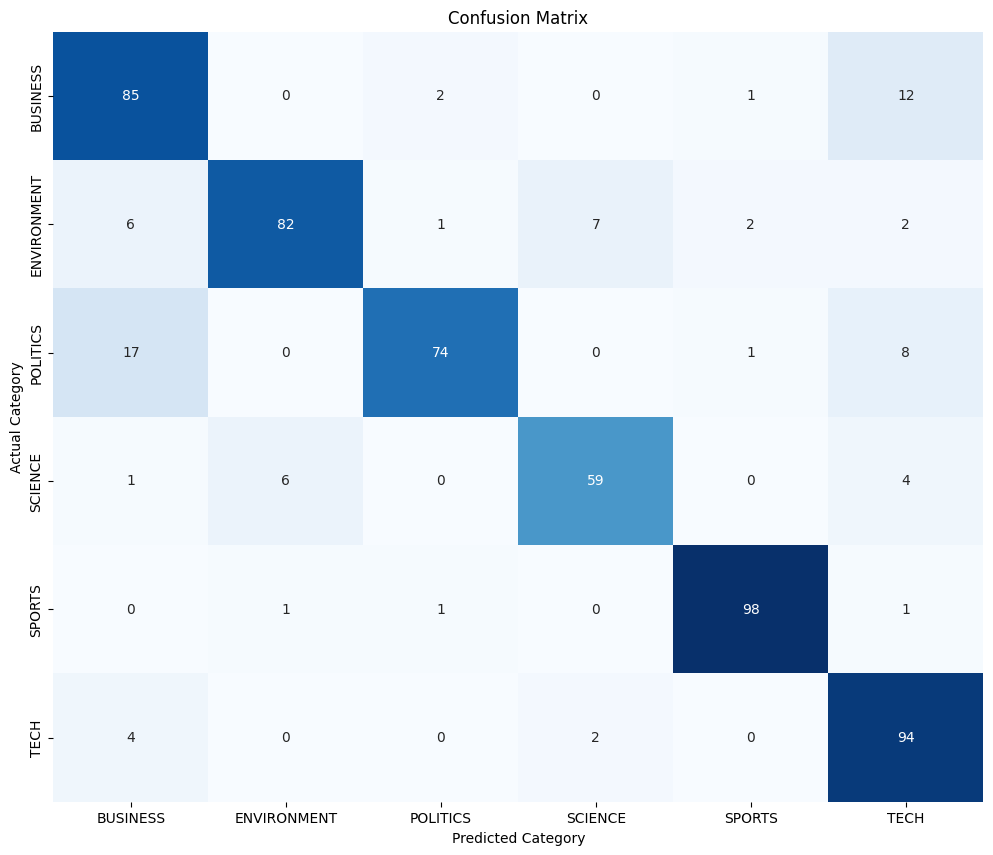

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the common unique values between actual and predicted categories
common_labels = set(result_df['category'].unique()) & set(result_df['predicted_category'].unique())

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap using seaborn
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False,
            xticklabels=sorted(common_labels),
            yticklabels=sorted(common_labels))

# Set labels and title
plt.xlabel('Predicted Category')
plt.ylabel('Actual Category')
plt.title('Confusion Matrix')

# Show the plot
plt.show()
